In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
from tqdm import trange

In [2]:
!pip install torchviz
!pip install torchsummary


In [3]:
import torchviz
import torchsummary

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# [Ramka danych](https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models)

In [5]:
! wget -c http://tomgrad.fizyka.pw.edu.pl/resources/cats.pt

--2025-01-15 06:48:39--  http://tomgrad.fizyka.pw.edu.pl/resources/cats.pt
Resolving tomgrad.fizyka.pw.edu.pl (tomgrad.fizyka.pw.edu.pl)... 194.29.174.239
Connecting to tomgrad.fizyka.pw.edu.pl (tomgrad.fizyka.pw.edu.pl)|194.29.174.239|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193499883 (185M)
Saving to: ‘cats.pt’

cats.pt             100%[===================>] 184.54M  3.00MB/s    in 58s     

2025-01-15 06:49:38 (3.17 MB/s) - ‘cats.pt’ saved [193499883/193499883]



In [6]:
with open("cats.pt", "rb") as f:
    data = torch.load(f)
data = data/255
ds = TensorDataset(data)
dl = DataLoader(ds, batch_size=64, shuffle=True)

<ipython-input-6-a96ffb74c462>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f)


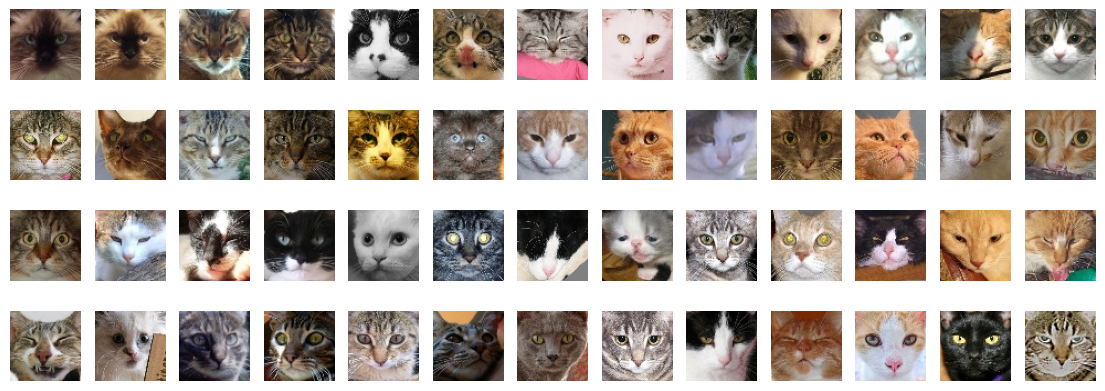

In [7]:
n_rows, n_cols, i = 4, 13, 1
plt.figure(figsize=(n_cols+1, n_rows+1))
for im in data[:n_rows*n_cols].movedim(1, 3):
    plt.subplot(n_rows, n_cols, i)
    plt.imshow(im)
    plt.axis('off')
    i += 1

In [8]:
data.shape

torch.Size([15747, 3, 64, 64])

In [9]:
def down_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels,
                  kernel_size=3, padding=1, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )


def up_block(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3,
                           padding=1, output_padding=1, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [10]:
class Model(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 8, 1),         # 8, 64, 64
            down_block(8, 16),          # 16, 32, 32
            down_block(16, 32),         # 32, 16, 16
            down_block(32, 64),         # 64, 8, 8
            down_block(64, 128),        # 128, 4, 4
            nn.Flatten(),               # 4*4*128
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
        )

        self.lin1 = nn.Linear(256, latent_dim)  # warstwa na mu (średnia)
        self.lin2 = nn.Linear(256, latent_dim)  # warstwa na logvar (logarytm wariancji)

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            up_block(128, 64),
            up_block(64, 32),
            up_block(32, 16),
            up_block(16, 8),
            nn.Conv2d(8, 3, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.enc(x)
        mu, logvar = self.lin1(x), self.lin2(x)
        return mu, logvar

    def decode(self, x):
        return self.dec(x)

    def forward(self, x):
        mu, logvar = self.encode(x)         # kodowanie
        sigma = torch.exp(0.5 * logvar)     # odchylenie standardowe
        epsilon = torch.randn_like(mu)
        z = mu+sigma*epsilon            # reparametrization trick
        x = self.decode(z)              # rekonstrukcja
        return x, mu, logvar            # zwracamy również mu i logvar (potrzebne do KL Loss)

In [11]:
latent_dim = 64
model = Model(latent_dim).to(device)
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# waga kl_weight mówi, jak silna ma być regularyzacja

def train_loop(kl_weight=0.0):
    total_loss = 0
    total_rec_loss = 0  # błąd rekonstrukcji
    total_kl_loss = 0   # regularyzacja

    for X, in dl:
        X = X.to(device)
        opt.zero_grad()

        Y, mu, logvar = model(X)
        reconstruction_loss = loss_fn(Y, X)
        kl_divergence = torch.mean(-0.5 * torch.sum(1 +
                                   logvar - mu ** 2 - logvar.exp(), dim=1), dim=0)
        loss = reconstruction_loss + kl_weight*kl_divergence

        loss.backward()
        opt.step()

        total_rec_loss += reconstruction_loss.item()
        total_kl_loss += kl_divergence.item()
        total_loss += loss.item()

    return total_loss, total_rec_loss, total_kl_loss

In [13]:
loss_history=[]

100%|██████████| 10/10 [13:14<00:00, 79.41s/it, kl=7.64e+3, loss=4.59, reconstruction=3.82]


Text(0, 0.5, 'Błąd')

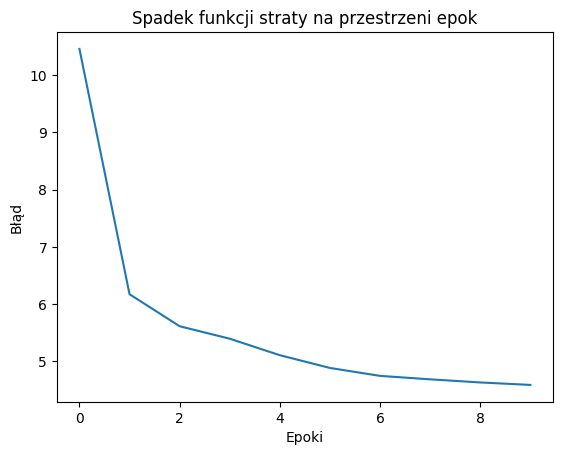

In [14]:
epochs = 10
loop = trange(epochs)
for epoch in loop:
    loss, rec_loss, kl_loss = train_loop(0.0001)
    loss_history.append(loss)
    loop.set_postfix(loss=loss, reconstruction=rec_loss, kl=kl_loss)
plt.plot(loss_history)
plt.title("Spadek funkcji straty na przestrzeni epok")
plt.xlabel("Epoki")
plt.ylabel("Błąd")

# Rekonstrukcja
$x \rightarrow z \rightarrow x'$

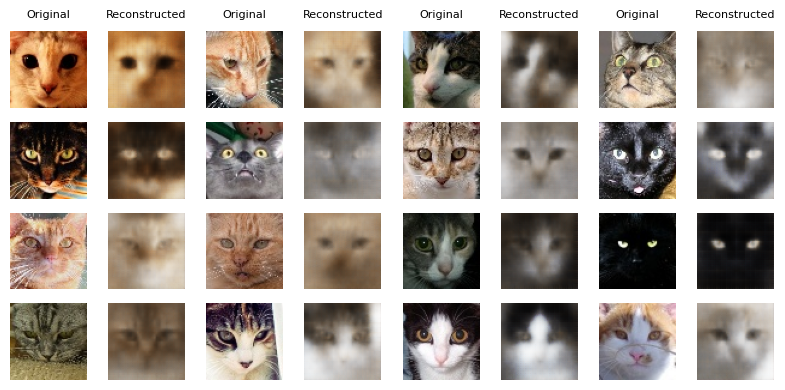

In [17]:
n_rows, n_cols, i = 4, 4, 1
idx = torch.randint(len(ds), (n_rows*n_cols,))  # Wybór losowych indeksów
original, = ds[idx]

with torch.no_grad():
    reconstructed = model(original.to(device))[0].cpu().detach()

# Tworzenie figurki
plt.figure(figsize=(n_cols*2, n_rows))

# Dodanie podpisów do kolumn
for i in range(len(idx)):
    # Wyświetlanie oryginalnych obrazów
    plt.subplot(n_rows, n_cols*2, 2*i+1)
    plt.imshow(original[i].movedim(0, 2))
    plt.axis('off')

    # Wyświetlanie rekonstruowanych obrazów
    plt.subplot(n_rows, n_cols*2, 2*i+2)
    plt.imshow(reconstructed[i].movedim(0, 2))
    plt.axis('off')

# Dodanie podpisów na górze kolumn
for i in range(n_cols):
    plt.subplot(n_rows, n_cols*2, 2*i+1)
    plt.title("Original", fontsize=8, pad=10)  # Tytuł dla oryginalnych obrazów
    plt.subplot(n_rows, n_cols*2, 2*i+2)
    plt.title("Reconstructed", fontsize=8, pad=10)  # Tytuł dla rekonstruowanych obrazów

plt.tight_layout()
plt.show()


# Generacja
losujemy $z$ z rozkładu $N(0, 1)$

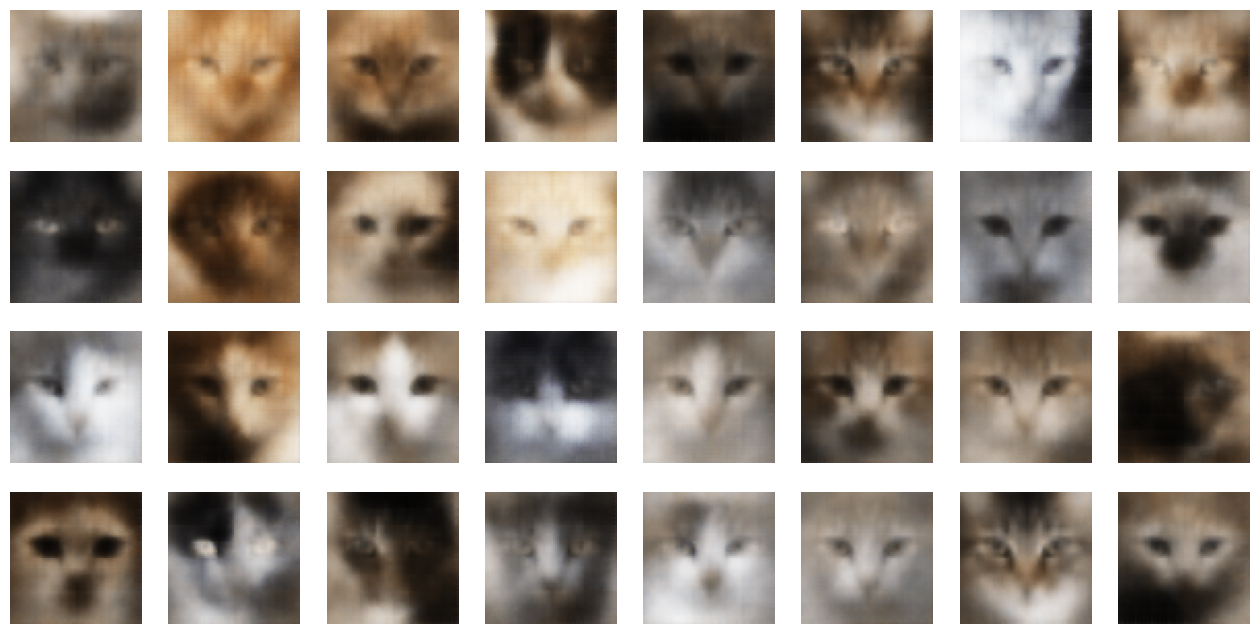

In [21]:
n_rows, n_cols = 4, 8
z = torch.randn(n_rows*n_cols, latent_dim).to(device)

with torch.no_grad():
    generated = model.decode(z).cpu().detach()

fig, axs = plt.subplots(n_rows, n_cols, figsize=(2*n_cols,2*n_rows))

for im, ax in zip(generated, axs.flatten()):
    ax.imshow(im.movedim(0, 2))
    ax.axis("off")

In [24]:
from torchsummary import summary

latent_dim = 64
model = Model(latent_dim).to(device)

# Podsumowanie kodera
print("Encoder Summary:")
summary(model.enc, input_size=(3, 64, 64))

# Podsumowanie dekodera
print("\nDecoder Summary:")
summary(model.dec, input_size=(latent_dim,))

Encoder Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]              32
            Conv2d-2           [-1, 16, 32, 32]           1,168
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 16, 16]           4,640
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
            Conv2d-8             [-1, 64, 8, 8]          18,496
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 4, 4]          73,856
      BatchNorm2d-12            [-1, 128, 4, 4]             256
             ReLU-13            [-1, 128, 4, 4]               0
          Flatten-14  